This notebook opens the Greenland FirnCover data and puts it into pandas dataframes.
The core data comes from core_data_df.pkl, which is created by running firncover_core_data_df.py
(The dataframe is created in that script.)

In [48]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import tables as tb
import datetime
import pandas as pd
import calendar
import scipy.io as spio
from datetime import datetime, timedelta
import pickle
import h5py as h5
from dateutil import parser
import time
import seaborn as sns
#testing

In [2]:
# Default Settings for figures
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['figure.figsize'] = [10, 8]
palette = sns.color_palette()

In [3]:
# Things to change
figex = '_220613.eps' #extension for figures (name plus type)
pathtodata = '/Users/dylenswan/FirnCover/'
date1 = '2021_07_30' # Date on the hdf5 file

In [4]:
# %matplotlib inline

In [5]:
R          = 8.314                          # gas constant used to calculate Arrhenius's term
S_PER_YEAR = 31557600.0                     # number of seconds in a year
spy = S_PER_YEAR
RHO_1      = 550.0                          # cut off density for the first zone densification (kg/m^3)
RHO_2      = 815.0                          # cut off density for the second zone densification (kg/m^3)
RHO_I      = 917.0                          # density of ice (kg/m^3)
RHO_I_MGM  = 0.917                          # density of ice (g/m^3)
RHO_1_MGM  = 0.550                          # cut off density for the first zone densification (g/m^3)
GRAVITY    = 9.8                            # acceleration due to gravity on Earth
K_TO_C     = 273.15                         # conversion from Kelvin to Celsius
BDOT_TO_A  = S_PER_YEAR * RHO_I_MGM         # conversion for accumulation rate
RHO_W_KGM  = 1000.                          # density of water
P_0 = 1.01325e5

def hl_analytic(rhos0, h, THL, AHL):
    '''
    Model steady-state firn density and age profiles and bubble close-off, uses m w.e. a^-1

    :param rhos0: surface density
    :param h: depth
    :param THL: 
    :param AHL:

    :return age: age vector of firn column with steady-state dynamics
    :return rho: density vector of firn column with steady state dynamics
    '''

    hSize = np.size(h)
    rhos = rhos0 / 1000.0

    A = AHL * RHO_I_MGM
    k0 = 11.0 * np.exp(-10160 / (R * THL))
    k1 = 575.0 * np.exp(-21400 / (R * THL))

    # depth of critical density, eqn 8 from Herron and Langway
    h0_55 = 1 / (RHO_I_MGM * k0) * (np.log(RHO_1_MGM / (RHO_I_MGM - RHO_1_MGM)) - np.log(rhos / (RHO_I_MGM - rhos)))
    Z0 = np.exp(RHO_I_MGM * k0 * h + np.log(rhos / (RHO_I_MGM - rhos)))

    # The boundary from zone 1 to zone 2 = t0_55
    t0_55 = 1 / (k0 * A) * np.log((RHO_I_MGM - rhos) / (RHO_I_MGM - RHO_1_MGM))
    rho_h0 = (RHO_I_MGM * Z0) / (1 + Z0)
    if np.max(rho_h0) >= RHO_I_MGM:
        t0 = np.zeros(hSize)
        for jj in range(hSize):
            if rho_h0[jj] <= RHO_I_MGM - 0.001:
                t0[jj] = (1 / (k0 * A) * np.log((RHO_I_MGM - rhos) / (RHO_I_MGM - rho_h0[jj])))
                jj_max = jj
            else:
                t0[jj] = (t0[jj_max])
    else:
        t0 = 1 / (k0 * A) * np.log((RHO_I_MGM - rhos) / (RHO_I_MGM - rho_h0))

    Z1 = np.exp(RHO_I_MGM * k1 * (h - h0_55) / np.sqrt(A) + np.log(RHO_1_MGM / (RHO_I_MGM - RHO_1_MGM)))
    Z = np.concatenate((Z0[h < h0_55], Z1[h > h0_55]))
    rho_h = (RHO_I_MGM * Z) / (1 + Z)
    tp = np.ones(hSize)
    for j in range(hSize):
        if rho_h[j] < RHO_I_MGM - 0.01:
            tp[j] = 1 / (k1 * np.sqrt(A)) * np.log((RHO_I_MGM - RHO_1_MGM) / (RHO_I_MGM - rho_h[j])) + t0_55
            jMax = j
        else:
            tp[j] = tp[jMax]

    # Zone 1 and Zone 2 repsectively
    age = np.concatenate((t0[h < h0_55], tp[h > h0_55])) * S_PER_YEAR
    rho = rho_h * 1000

    return age, rho

In [6]:
def toYearFraction(date):
    '''
    convert datetime to decimal date 
    '''
    def sinceEpoch(date): # returns seconds since epoch
        return calendar.timegm(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [7]:
def smooth(x,window_len=14,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')

    return y[int(window_len/2-1):-int(window_len/2)]

def butter_lowpass_filter(dd, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sps.butter(order, normal_cutoff, btype='low', analog=False)
    y = sps.filtfilt(b, a, dd)
    return y

def strainfun(arr):
    strain = -1*np.log(arr/arr.iloc[0])
    return strain

In [8]:
# with open('/Users/maxstev/Documents/Grad_School/Research/FIRN/GREENLAND_CVN/Data/CVN_DATA/core_data_dict.pkl','rb') as f:
#     d=pickle.load(f)
# core_df = pd.DataFrame.from_dict(d,orient='index')
# core_df.index.name='coreid'

In [9]:
sites=['Summit','KAN-U','NASA-SE','Crawford','EKT','Saddle','EastGrip','DYE-2']

In [10]:
pathtodata

'/Users/dylenswan/FirnCover/'

In [11]:
### Import the core depth/density data.
# with open(os.path.join(pathtodata,'core_data_df.pkl'),'rb') as f:
#     core_df=pickle.load(f)

In [12]:
### Import the FirnCover data tables. 
filename='FirnCoverData_2_0_' + date1 + '.h5'
filepath=os.path.join(pathtodata,filename)
CVNfile=tb.open_file(filepath, mode='r', driver="H5FD_CORE")
datatable=CVNfile.root.FirnCover
epoch =np.datetime64('1970-01-01')

In [13]:
inst_meta_df = pd.DataFrame.from_records(datatable.Compaction_Instrument_Metadata[:])
inst_meta_df.sitename=inst_meta_df.sitename.str.decode("utf-8")
inst_meta_df.set_index('instrument_ID',inplace=True)
# inst_meta_df.loc[7,'borehole_bottom_from_surface_m']

In [14]:
datatable

/FirnCover (Group) 'FirnCover'
  children := ['Air_Temp_Hourly' (Table), 'Compaction_Daily' (Table), 'Compaction_Instrument_Metadata' (Table), 'Firn_Temp_Daily' (Table), 'Meteorological_Daily' (Table), 'Station_Metadata' (Table), 'Station_Visit_Notes' (Table)]

In [15]:
airtemp_df = pd.DataFrame.from_records(datatable.Air_Temp_Hourly[:])
airtemp_df.sitename = airtemp_df.sitename.str.decode("utf-8")
airtemp_df['date'] = pd.to_datetime(airtemp_df.daynumber_YYYYMMDD,format='%Y%m%d')+pd.to_timedelta(airtemp_df.hournumber_HH,unit='h')
airtemp_df.set_index(['sitename','date'],inplace=True)

In [16]:
airtemp_df2 = airtemp_df['air_temp_C']

In [17]:
airtemp_df2.loc['KAN-U'].resample('a').mean()

date
2013-12-31   -22.818296
2014-12-31   -17.317461
2015-12-31   -18.572308
2016-12-31   -14.010118
2017-12-31   -13.957590
2018-12-31   -31.450445
2019-12-31   -63.105392
Freq: A-DEC, Name: air_temp_C, dtype: float32

In [18]:
# compaction_df.head(3)
# inst_meta_df.head(3)

In [19]:
### First set up the compaction data frame, basic.

compaction_df=pd.DataFrame.from_records(datatable.Compaction_Daily[:])
compaction_df.sitename=compaction_df.sitename.str.decode("utf-8")
compaction_df['date']=pd.to_datetime(compaction_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
compaction_df.set_index(['instrument_id','date'],inplace=True)
compaction_df.drop(columns=["compaction_ratio","compaction_wire_correction_ratio","compaction_cable_distance_m"],inplace=True)
compaction_df.sort_index(inplace=True)

uids = compaction_df.index.get_level_values(0).unique()
compaction_df['hole_init_length']=0*compaction_df['compaction_borehole_length_m']
compaction_df['hole_botfromsurf']=0*compaction_df['compaction_borehole_length_m']
compaction_df['hole_topfromsurf']=0*compaction_df['compaction_borehole_length_m']

for ii in uids:
    compaction_df.loc[ii,'hole_init_length'] = -1*inst_meta_df.loc[ii,'borehole_initial_length_m']*np.ones_like(compaction_df.loc[ii,"compaction_borehole_length_m"].values)
    compaction_df.loc[ii,'hole_botfromsurf'] = -1*inst_meta_df.loc[ii,'borehole_bottom_from_surface_m']*np.ones_like(compaction_df.loc[ii,"compaction_borehole_length_m"].values)
    compaction_df.loc[ii,'hole_topfromsurf'] = -1*inst_meta_df.loc[ii,'borehole_top_from_surface_m']*np.ones_like(compaction_df.loc[ii,"compaction_borehole_length_m"].values)
#Filter saddle data.
compaction_df.drop(compaction_df[((compaction_df.sitename=='Saddle')&(compaction_df.index.get_level_values("date")<'2016-01-01'))].index,inplace=True)    

In [20]:
compaction_df

sitename  daynumber_YYYYMMDD  \
instrument_id date                                      
1             2013-04-29    KAN-U            20130429   
              2013-04-30    KAN-U            20130430   
              2013-05-01    KAN-U            20130501   
              2013-05-02    KAN-U            20130502   
              2013-05-03    KAN-U            20130503   
...                           ...                 ...   
50            2018-10-03   Summit            20181003   
              2018-10-04   Summit            20181004   
              2018-10-05   Summit            20181005   
              2018-10-06   Summit            20181006   
              2018-10-07   Summit            20181007   

                          compaction_borehole_length_m  borehole_depth_top_m  \
instrument_id date                                                             
1             2013-04-29                      5.000000           -999.000000   
              2013-04-30                      4.999187           -999.000000   
              2013-05-01                      4.998374           -999.000000   
              2013-05-02                      4.997561           -999.000000   
              2013-05-03                      4.995936           -999.000000   
...                                                ...                   ...   
50            2018-10-03                     21.622648              0.839951   
              2018-10-04                     21.621580              0.833865   
              2018-10-05                     21.620691              0.841777   
              2018-10-06                     21.619558              0.848046   
              2018-10-07                     21.618685              0.839027   

                          borehole_depth_bottom_m  hole_init_length  \
instrument_id date                                                    
1             2013-04-29              -999.000000              5.00   
              2013-04-30              -999.000000              5.00   
              2013-05-01              -999.000000              5.00   
              2013-05-02              -999.000000              5.00   
              2013-05-03              -999.000000              5.00   
...                                           ...               ...   
50            2018-10-03                22.462599             21.99   
              2018-10-04                22.455446             21.99   
              2018-10-05                22.462467             21.99   
              2018-10-06                22.467604             21.99   
              2018-10-07                22.457712             21.99   

                          hole_botfromsurf  hole_topfromsurf  
instrument_id date                                            
1             2013-04-29              6.20               1.2  
              2013-04-30              6.20               1.2  
              2013-05-01              6.20               1.2  
              2013-05-02              6.20               1.2  
              2013-05-03              6.20               1.2  
...                                    ...               ...  
50            2018-10-03             21.99              -0.0  
              2018-10-04             21.99              -0.0  
              2018-10-05             21.99              -0.0  
              2018-10-06             21.99              -0.0  
              2018-10-07             21.99              -0.0  

[54601 rows x 8 columns]

In [21]:
# #Put the 'virtual' holes into the frame (i.e. the differential compaction between holes), Summit, EGRIP only for now.

# ### Summmit
# cd2 = compaction_df.loc[31].copy()
# cd2.hole_init_length = compaction_df.loc[30,'hole_init_length']-compaction_df.loc[31,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[30,'hole_botfromsurf'],compaction_df.loc[31,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[30,'hole_botfromsurf'],compaction_df.loc[31,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[30,'compaction_borehole_length_m']-compaction_df.loc[31,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(101)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[31].copy()
# cd2.hole_init_length = compaction_df.loc[30,'hole_init_length']-compaction_df.loc[32,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[30,'hole_botfromsurf'],compaction_df.loc[32,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[30,'hole_botfromsurf'],compaction_df.loc[32,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[30,'compaction_borehole_length_m']-compaction_df.loc[32,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(102)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[31].copy()
# cd2.hole_init_length = compaction_df.loc[32,'hole_init_length']-compaction_df.loc[31,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[32,'hole_botfromsurf'],compaction_df.loc[31,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[32,'hole_botfromsurf'],compaction_df.loc[31,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[32,'compaction_borehole_length_m']-compaction_df.loc[31,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(103)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])
# #####

# #### EastGRIP

# # compaction_df.loc[28,'2015-05-28']=compaction_df.loc[28,'2015-05-29']
# # compaction_df.loc[29,'2015-05-28']=compaction_df.loc[29,'2015-05-29']
# compaction_df.drop((27,'2015-05-28'),inplace=True)
# compaction_df.drop((26,'2015-05-28'),inplace=True)

# cd2 = compaction_df.loc[26].copy()
# cd2.hole_init_length = compaction_df.loc[26,'hole_init_length']-compaction_df.loc[28,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[26,'hole_botfromsurf'],compaction_df.loc[28,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[26,'hole_botfromsurf'],compaction_df.loc[28,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[26,'compaction_borehole_length_m']-compaction_df.loc[28,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(104)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[26].copy()
# cd2.hole_init_length = compaction_df.loc[26,'hole_init_length']-compaction_df.loc[27,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[26,'hole_botfromsurf'],compaction_df.loc[27,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[26,'hole_botfromsurf'],compaction_df.loc[27,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[26,'compaction_borehole_length_m']-compaction_df.loc[27,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(105)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[28].copy()
# cd2.hole_init_length = compaction_df.loc[28,'hole_init_length']-compaction_df.loc[27,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[28,'hole_botfromsurf'],compaction_df.loc[27,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[28,'hole_botfromsurf'],compaction_df.loc[27,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[28,'compaction_borehole_length_m']-compaction_df.loc[27,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(106)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# ### NASA-SE
# cd2 = compaction_df.loc[13].copy()
# cd2.hole_init_length = compaction_df.loc[13,'hole_init_length']-compaction_df.loc[14,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[13,'hole_botfromsurf'],compaction_df.loc[14,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[13,'hole_botfromsurf'],compaction_df.loc[14,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[13,'compaction_borehole_length_m']-compaction_df.loc[14,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(107)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[13].copy()
# cd2.hole_init_length = compaction_df.loc[13,'hole_init_length']-compaction_df.loc[15,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[13,'hole_botfromsurf'],compaction_df.loc[15,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[13,'hole_botfromsurf'],compaction_df.loc[15,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[13,'compaction_borehole_length_m']-compaction_df.loc[15,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(108)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# cd2 = compaction_df.loc[13].copy()
# cd2.hole_init_length = compaction_df.loc[15,'hole_init_length']-compaction_df.loc[14,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[15,'hole_botfromsurf'],compaction_df.loc[14,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[15,'hole_botfromsurf'],compaction_df.loc[14,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[15,'compaction_borehole_length_m']-compaction_df.loc[14,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(109)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])
# #######

# ### Crawford
# # 22-24
# cd2 = compaction_df.loc[22].copy()
# cd2.hole_init_length = compaction_df.loc[22,'hole_init_length']-compaction_df.loc[24,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[24,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[24,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[22,'compaction_borehole_length_m']-compaction_df.loc[24,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(110)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# # 22-25
# cd2 = compaction_df.loc[22].copy()
# cd2.hole_init_length = compaction_df.loc[22,'hole_init_length']-compaction_df.loc[25,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[25,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[25,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[22,'compaction_borehole_length_m']-compaction_df.loc[25,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(111)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# # 22-23
# cd2 = compaction_df.loc[22].copy()
# cd2.hole_init_length = compaction_df.loc[22,'hole_init_length']-compaction_df.loc[23,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[22,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[22,'compaction_borehole_length_m']-compaction_df.loc[23,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(112)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# # 24-25
# cd2 = compaction_df.loc[22].copy()
# cd2.hole_init_length = compaction_df.loc[24,'hole_init_length']-compaction_df.loc[25,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[24,'hole_botfromsurf'],compaction_df.loc[25,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[24,'hole_botfromsurf'],compaction_df.loc[25,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[24,'compaction_borehole_length_m']-compaction_df.loc[25,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(113)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# # 24-23
# cd2 = compaction_df.loc[24].copy()
# cd2.hole_init_length = compaction_df.loc[24,'hole_init_length']-compaction_df.loc[23,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[24,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[24,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[24,'compaction_borehole_length_m']-compaction_df.loc[23,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(114)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])

# #25-23
# cd2 = compaction_df.loc[24].copy()
# cd2.hole_init_length = compaction_df.loc[25,'hole_init_length']-compaction_df.loc[23,'hole_init_length']
# cd2.hole_botfromsurf = pd.concat([compaction_df.loc[25,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).max(axis=1)
# cd2.hole_topfromsurf = pd.concat([compaction_df.loc[25,'hole_botfromsurf'],compaction_df.loc[23,'hole_botfromsurf']],axis=1).min(axis=1)
# cd2.compaction_borehole_length_m = compaction_df.loc[25,'compaction_borehole_length_m']-compaction_df.loc[23,'compaction_borehole_length_m']
# cd2['Compaction_Instrument_ID'] = int(115)
# cd2.set_index(['Compaction_Instrument_ID',cd2.index],inplace=True)
# compaction_df = pd.concat([compaction_df,cd2])
# idx=compaction_df.index
# compaction_df.index=compaction_df.index.set_levels([idx.levels[0].astype(int),idx.levels[1]])


In [22]:
compaction_df.keys()

Index(['sitename', 'daynumber_YYYYMMDD', 'compaction_borehole_length_m',
       'borehole_depth_top_m', 'borehole_depth_bottom_m', 'hole_init_length',
       'hole_botfromsurf', 'hole_topfromsurf'],
      dtype='object')

In [23]:
compaction_df.groupby(level=0)['compaction_borehole_length_m'].apply(lambda x: x.iloc[0]-x)

instrument_id  date      
1              2013-04-29    0.000000
               2013-04-30    0.000813
               2013-05-01    0.001626
               2013-05-02    0.002439
               2013-05-03    0.004064
                               ...   
50             2018-10-03    0.367352
               2018-10-04    0.368420
               2018-10-05    0.369308
               2018-10-06    0.370441
               2018-10-07    0.371315
Name: compaction_borehole_length_m, Length: 54601, dtype: float32

In [24]:
# Now do figure out the compaction rates and strain on all the holes.
compaction_df['compdiff']=compaction_df.groupby(level=0)['compaction_borehole_length_m'].diff()
compaction_df['totcomp']=compaction_df.groupby(level=0)['compaction_borehole_length_m'].apply(lambda x: x.iloc[0]-x)
msk = compaction_df['compdiff']>0
compaction_df.loc[msk,'compdiff']=0
compaction_df['compdiff'].fillna(value=0,inplace=True)
compaction_df['strain']=compaction_df.groupby(level=0)['compaction_borehole_length_m'].apply(strainfun)
compaction_df['ss1970']=(compaction_df.index.get_level_values(1)-epoch).total_seconds()
compaction_df['filtstrain']=0*compaction_df['strain']
compaction_df['strainrate']=0*compaction_df['strain']
compaction_df['filtstrainrate']=0*compaction_df['strain']
compaction_df['comprate']=0*compaction_df['strain']
compaction_df['filttotcomp']=0*compaction_df['strain']
compaction_df['filtcomprate']=0*compaction_df['strain']

uids = compaction_df.index.get_level_values(0).unique()
for ii in uids:
    grad = np.gradient(compaction_df['strain'][ii],compaction_df['ss1970'][ii])
    compaction_df.loc[ii,'strainrate'] = grad # units: per second
    comprate = np.gradient(compaction_df['totcomp'][ii],compaction_df['ss1970'][ii])
    compaction_df.loc[ii,'comprate'] = comprate # units: per second
    try:
        filtstr = smooth(compaction_df['strain'][ii])
        filtgrad = np.gradient(filtstr,compaction_df['ss1970'][ii])
        compaction_df.loc[ii,'filtstrain'] = filtstr # units: per second
        compaction_df.loc[ii,'filtstrainrate'] = filtgrad
        
        filtcomp = smooth(compaction_df['totcomp'][ii])
        filtcomprate = np.gradient(filtcomp,compaction_df['ss1970'][ii])
        compaction_df.loc[ii,'filttotcomp'] = filtcomp # units: per second
        compaction_df.loc[ii,'filtcomprate'] = filtcomprate
    except:
        pass

Text(0, 0.5, 'Compaction Rate (m a$^{-1}$)')

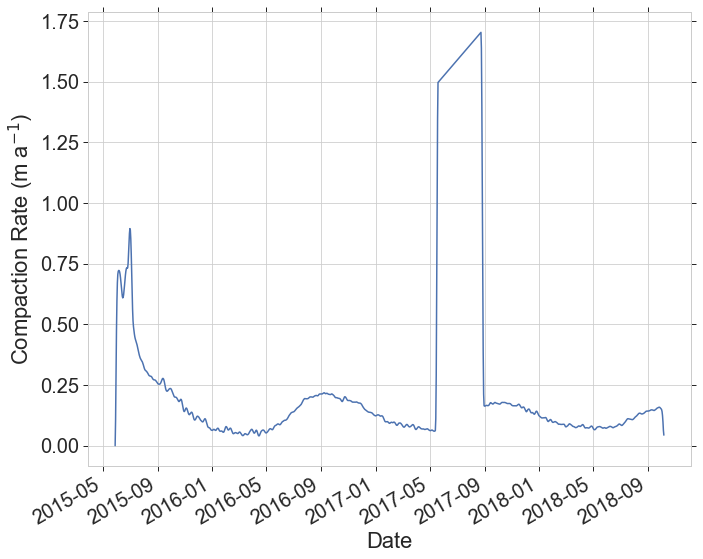

In [25]:
fcr,acr=plt.subplots()
(compaction_df.loc[31,'filtcomprate']*spy).plot(ax=acr)
acr.grid(True)
acr.set_xlabel('Date')
acr.set_ylabel('Compaction Rate (m a$^{-1}$)')

<AxesSubplot:xlabel='date'>

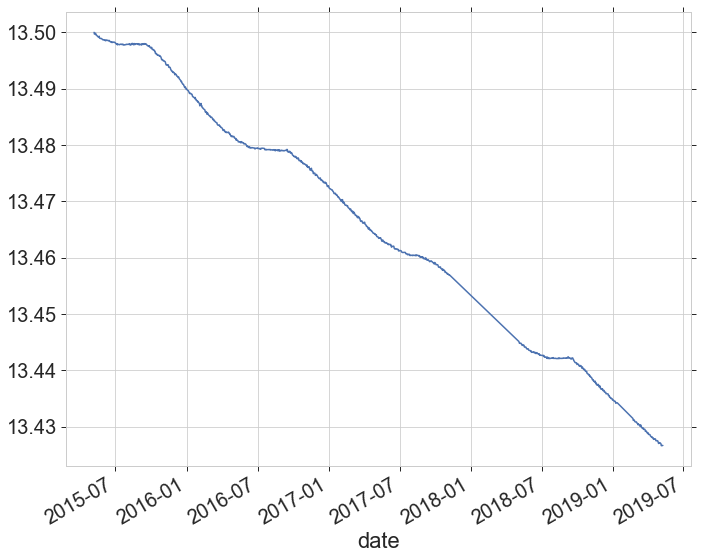

In [26]:
f2,a2=plt.subplots(figsize=(10,8))
(compaction_df.loc[11].compaction_borehole_length_m).plot(ax=a2)

Text(0, 0.5, 'Strain rate')

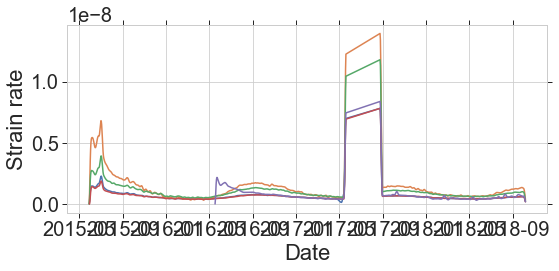

In [27]:
f1,a1 = plt.subplots(figsize=(8,4))
a1.plot(compaction_df.loc[30,'filtstrainrate'])
a1.plot(compaction_df.loc[31,'filtstrainrate'])
a1.plot(compaction_df.loc[32,'filtstrainrate'])
a1.plot(compaction_df.loc[33,'filtstrainrate'])
a1.plot(compaction_df.loc[41,'filtstrainrate'])
a1.grid(True)
a1.set_xlabel('Date')
a1.set_ylabel('Strain rate')

Text(0, 0.5, 'Total Compaction')

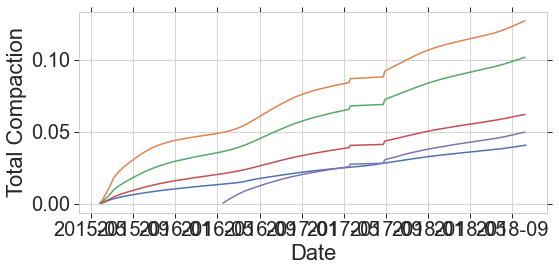

In [28]:
f1,a1 = plt.subplots(figsize=(8,4))
a1.plot(compaction_df.loc[26,'filtstrain'])
a1.plot(compaction_df.loc[31,'filtstrain'])
a1.plot(compaction_df.loc[32,'filtstrain'])
a1.plot(compaction_df.loc[33,'filtstrain'])
a1.plot(compaction_df.loc[41,'filtstrain'])
a1.grid(True)
a1.set_xlabel('Date')
a1.set_ylabel('Total Compaction')

Text(0, 0.5, 'Total Compaction')

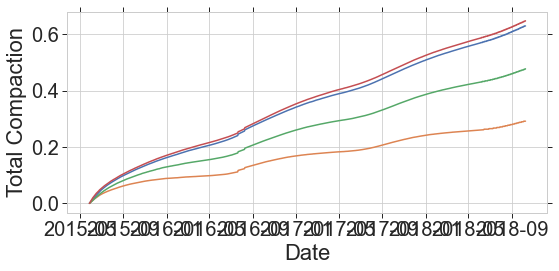

In [29]:
f1,a1 = plt.subplots(figsize=(8,4))
a1.plot(compaction_df.loc[26,'totcomp'])
a1.plot(compaction_df.loc[27,'totcomp'])
a1.plot(compaction_df.loc[28,'totcomp'])
a1.plot(compaction_df.loc[29,'totcomp'])
# a1.plot(compaction_df.loc[41,'totcomp'])
a1.grid(True)
a1.set_xlabel('Date')
a1.set_ylabel('Total Compaction')

In [30]:
compaction_df.head()

sitename  daynumber_YYYYMMDD  \
instrument_id date                                      
1             2013-04-29    KAN-U            20130429   
              2013-04-30    KAN-U            20130430   
              2013-05-01    KAN-U            20130501   
              2013-05-02    KAN-U            20130502   
              2013-05-03    KAN-U            20130503   

                          compaction_borehole_length_m  borehole_depth_top_m  \
instrument_id date                                                             
1             2013-04-29                      5.000000                -999.0   
              2013-04-30                      4.999187                -999.0   
              2013-05-01                      4.998374                -999.0   
              2013-05-02                      4.997561                -999.0   
              2013-05-03                      4.995936                -999.0   

                          borehole_depth_bottom_m  hole_init_length  \
instrument_id date                                                    
1             2013-04-29                   -999.0               5.0   
              2013-04-30                   -999.0               5.0   
              2013-05-01                   -999.0               5.0   
              2013-05-02                   -999.0               5.0   
              2013-05-03                   -999.0               5.0   

                          hole_botfromsurf  hole_topfromsurf  compdiff  \
instrument_id date                                                       
1             2013-04-29               6.2               1.2  0.000000   
              2013-04-30               6.2               1.2 -0.000813   
              2013-05-01               6.2               1.2 -0.000813   
              2013-05-02               6.2               1.2 -0.000813   
              2013-05-03               6.2               1.2 -0.001626   

                           totcomp    strain        ss1970  filtstrain  \
instrument_id date                                                       
1             2013-04-29  0.000000 -0.000000  1.367194e+09    0.000341   
              2013-04-30  0.000813  0.000163  1.367280e+09    0.000341   
              2013-05-01  0.001626  0.000325  1.367366e+09    0.000400   
              2013-05-02  0.002439  0.000488  1.367453e+09    0.000509   
              2013-05-03  0.004064  0.000813  1.367539e+09    0.000649   

                            strainrate  filtstrainrate      comprate  \
instrument_id date                                                     
1             2013-04-29  1.882114e-09   -1.254864e-24  9.409807e-09   
              2013-04-30  1.881578e-09    3.439477e-10  9.407048e-09   
              2013-05-01  1.881883e-09    9.696407e-10  9.407048e-09   
              2013-05-02  2.824204e-09    1.439577e-09  1.411195e-08   
              2013-05-03  2.824664e-09    1.720788e-09  1.411195e-08   

                          filttotcomp  filtcomprate  
instrument_id date                                   
1             2013-04-29     0.001705  2.509727e-24  
              2013-04-30     0.001705  1.718684e-09  
              2013-05-01     0.002002  4.845185e-09  
              2013-05-02     0.002542  7.193209e-09  
              2013-05-03     0.003245  8.597875e-09

In [31]:
# df['tvalue'].shift().

In [32]:
df=compaction_df.loc[41].copy()
df['tvalue'] = df.index
df['delta'] = (df['tvalue']-df['tvalue'].shift())#.fillna(0)

In [33]:
statmeta_df=pd.DataFrame.from_records(datatable.Station_Metadata[:].tolist(),columns=datatable.Station_Metadata.colnames)
statmeta_df.sitename=statmeta_df.sitename.str.decode("utf-8")
statmeta_df.iridium_URL=statmeta_df.iridium_URL.str.decode("utf-8")
# pd.to_datetime(compaction_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
statmeta_df['install_date']=pd.to_datetime(statmeta_df.installation_daynumer_YYYYMMDD.values,format='%Y%m%d')
statmeta_df['rtd_date']=pd.to_datetime(statmeta_df.RTD_installation_daynumber_YYYYMMDD.values,format='%Y%m%d')
zz=[]
for ii in range(len(statmeta_df.RTD_depths_at_installation_m[0])):
    st = 'rtd%s' %ii
    zz.append(st)
    
statmeta_df[zz]=pd.DataFrame(statmeta_df.RTD_depths_at_installation_m.values.tolist(),index=statmeta_df.index)  
statmeta_df.set_index('sitename',inplace=True)
statmeta_df.loc['Crawford','rtd_date']=statmeta_df.loc['Crawford','install_date']
statmeta_df.loc['NASA-SE','rtd_date']=statmeta_df.loc['NASA-SE','install_date']-pd.Timedelta(days=1)

In [34]:
airtemp_df=pd.DataFrame.from_records(datatable.Air_Temp_Hourly[:])
airtemp_df.sitename=airtemp_df.sitename.str.decode("utf-8")
# pd.to_datetime(compaction_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
airtemp_df['date']=pd.to_datetime(airtemp_df.daynumber_YYYYMMDD.values*100+airtemp_df.hournumber_HH.values.astype('uint16'),format='%Y%m%d%H')
airtemp_df

,sitename,daynumber_YYYYMMDD,hournumber_HH,air_temp_C,date
0,KAN-U,20130429,17,-14.570000,2013-04-29 17:00:00
1,KAN-U,20130429,18,-15.780000,2013-04-29 18:00:00
2,KAN-U,20130429,19,-17.219999,2013-04-29 19:00:00
3,KAN-U,20130429,20,-19.299999,2013-04-29 20:00:00
4,KAN-U,20130429,21,-21.200001,2013-04-29 21:00:00
...,...,...,...,...,...
264084,EastGrip,20180606,11,-5.767000,2018-06-06 11:00:00
264085,EastGrip,20180606,12,-5.213000,2018-06-06 12:00:00
264086,EastGrip,20180606,13,-5.305000,2018-06-06 13:00:00
264087,EastGrip,20180606,14,-4.975000,2018-06-06 14:00:00


In [35]:
metdata_df=pd.DataFrame.from_records(datatable.Meteorological_Daily[:])
metdata_df.sitename=metdata_df.sitename.str.decode("utf-8")
# pd.to_datetime(compaction_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
metdata_df['date']=pd.to_datetime(metdata_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
for site in sites:
    msk=(metdata_df['sitename']==site)&(metdata_df['date']<statmeta_df.loc[site,'rtd_date'])
    metdata_df.drop(metdata_df[msk].index,inplace=True)
    if site=='NASA-SE':
        # NASA-SE had a new tower section in 5/17; distance raised is ??, use 1.7 m for now. 
        m2 = (metdata_df['sitename']==site)&(metdata_df['date']>'2017-05-10')
        metdata_df.loc[m2,'sonic_range_dist_corrected_m']=metdata_df.loc[m2,'sonic_range_dist_corrected_m']-1.7
    elif site=='Crawford':
        # Crawford has bad sonic data for 11/3/17 to 2/16/18
        m2 = (metdata_df['sitename']==site)&(metdata_df['date']>'2017-11-03')&(metdata_df['date']<'2018-02-16')
        metdata_df.loc[m2,'sonic_range_dist_corrected_m']=np.nan
    elif site=='EKT':
        # EKT had a new tower section in 5/17; distance raised is 0.86 m. 
        m2 = (metdata_df['sitename']==site)&(metdata_df['date']>'2017-05-05')
        metdata_df.loc[m2,'sonic_range_dist_corrected_m']=metdata_df.loc[m2,'sonic_range_dist_corrected_m']-0.86
    elif site=='Saddle':
        # Saddle had a new tower section in 5/17; distance raised is 1.715 m. 
        m2 = (metdata_df['sitename']==site)&(metdata_df['date']>'2017-05-07')
        metdata_df.loc[m2,'sonic_range_dist_corrected_m']=metdata_df.loc[m2,'sonic_range_dist_corrected_m']-1.715
    elif site=='EastGrip':
        # Eastgrip has bad sonic data for 11/7/17 onward 
        m2 = (metdata_df['sitename']==site)&(metdata_df['date']>'2017-11-17')
        metdata_df.loc[m2,'sonic_range_dist_corrected_m']=np.nan
        m3 = (metdata_df['sitename']==site)&(metdata_df['date']>'2015-10-01')&(metdata_df['date']<'2016-04-01')
        metdata_df.loc[m3,'sonic_range_dist_corrected_m']=np.nan
        m4 = (metdata_df['sitename']==site)&(metdata_df['date']>'2016-12-07')&(metdata_df['date']<'2017-03-01')
        metdata_df.loc[m4,'sonic_range_dist_corrected_m']=np.nan
    elif site=='DYE-2':
        # 
        m3 = (metdata_df['sitename']==site)&(metdata_df['date']>'2015-12-24')&(metdata_df['date']<'2016-05-01')
        metdata_df.loc[m3,'sonic_range_dist_corrected_m']=np.nan
#         m4 = (metdata_df['sitename']==site)&(metdata_df['date']>'2016-12-07')&(metdata_df['date']<'2017-03-01')
#         metdata_df.loc[m4,'sonic_range_dist_corrected_m']=np.nan
        
metdata_df.reset_index(drop=True)

,sitename,daynumber_YYYYMMDD,battery_min_V,battery_max_V,panel_temp_mean_C,air_temp_min_C,air_temp_median_C,air_temp_max_C,sonic_range_quality,sonic_range_quality_code,sonic_range_dist_raw_m,sonic_range_air_temp_C,sonic_range_dist_corrected_m,accum_snow_depth_m,accum_snow_depth_interpolated_m,accum_snow_depth_interpolated_flag,date
0,KAN-U,20150505,13.43,14.31,-11.720000,-13.670000,-13.190000,-10.900000,199,0,2.804,-13.670000,2.732935,0.000000,0.000000,0,2015-05-05
1,KAN-U,20150506,13.32,14.93,-9.570000,-16.889999,-10.650000,-6.382000,182,0,2.825,-16.709999,2.737226,-0.004291,-0.004291,0,2015-05-06
2,KAN-U,20150507,13.41,14.84,-7.835000,-15.510000,-11.500000,-3.858000,185,0,2.668,-3.858000,2.649091,0.083844,0.083844,0,2015-05-07
3,KAN-U,20150508,13.43,14.91,-8.830000,-17.469999,-8.620000,-4.530000,185,0,2.693,-17.030001,2.607699,0.125236,0.125236,0,2015-05-08
4,KAN-U,20150509,13.48,14.65,-8.170000,-12.150000,-9.500000,-8.710000,168,0,2.575,-12.150000,2.517079,0.215856,0.215856,0,2015-05-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,EastGrip,20181006,14.05,14.63,-26.610001,-33.340000,-27.209999,-23.700001,170,0,1.673,-25.290001,NaN,1.473876,1.473876,0,2018-10-06
9759,EastGrip,20181007,14.07,14.60,-34.709999,-38.709999,-36.389999,-28.010000,186,0,1.684,-28.010000,NaN,1.472224,1.472224,0,2018-10-07
9760,EastGrip,20181008,14.14,14.60,-32.200001,-36.369999,-33.220001,-28.530001,171,0,1.690,-29.080000,NaN,1.470038,1.470038,0,2018-10-08
9761,EastGrip,20181009,14.12,14.64,-35.009998,-38.459999,-35.169998,-32.730000,198,0,1.710,-34.980000,NaN,1.470789,1.470789,0,2018-10-09


In [36]:
sonic_df = metdata_df[['sitename','date','sonic_range_dist_corrected_m']].set_index(['sitename','date'])
sonic_df.columns = ['sonic_m']
sonic_df.sonic_m[sonic_df.sonic_m<-100]=np.nan
sonic_df.loc['Saddle','2015-05-16']=sonic_df.loc['Saddle','2015-05-17']

for site in sites:
    if site=='Summit':
        sonic_df.loc['Summit','sonic_m']=sonic_df.loc['Summit'].interpolate()
        sonic_df.loc['Summit','sonic_m']=smooth(sonic_df.loc['Summit','sonic_m'].values)
    elif site=='KAN-U':
        gradthresh = 0.1
        vals = sonic_df.loc['KAN-U','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['KAN-U','sonic_m']=vals
        sonic_df.loc['KAN-U','sonic_m']=sonic_df.loc['KAN-U'].interpolate(method='linear')
        sonic_df.loc['KAN-U','sonic_m']=smooth(sonic_df.loc['KAN-U','sonic_m'].values)
    elif site=='NASA-SE':
        sonic_df.loc['NASA-SE','sonic_m']=sonic_df.loc['NASA-SE'].interpolate()
        sonic_df.loc['NASA-SE','sonic_m']=smooth(sonic_df.loc['NASA-SE','sonic_m'].values)
    elif site=='Crawford':
        gradthresh = 0.1
        vals = sonic_df.loc['Crawford','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['Crawford','sonic_m']=vals
        sonic_df.loc['Crawford','sonic_m']=sonic_df.loc['Crawford'].interpolate(method='linear')
        sonic_df.loc['Crawford','sonic_m']=smooth(sonic_df.loc['Crawford','sonic_m'].values)
    elif site=='EKT':
        gradthresh = 0.1
        vals = sonic_df.loc['EKT','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['EKT','sonic_m']=vals
        sonic_df.loc['EKT','sonic_m']=sonic_df.loc['EKT'].interpolate(method='linear')
        sonic_df.loc['EKT','sonic_m']=smooth(sonic_df.loc['EKT','sonic_m'].values)
    elif site=='Saddle':
        gradthresh = 0.1
        vals = sonic_df.loc['Saddle','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['Saddle','sonic_m']=vals
        sonic_df.loc['Saddle','sonic_m']=sonic_df.loc['Saddle'].interpolate(method='linear')
        sonic_df.loc['Saddle','sonic_m']=smooth(sonic_df.loc['Saddle','sonic_m'].values)
    elif site=='EastGrip':
        gradthresh = 0.1
        vals = sonic_df.loc['EastGrip','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['EastGrip','sonic_m']=vals
        sonic_df.loc['EastGrip','sonic_m']=sonic_df.loc['EastGrip'].interpolate(method='linear')
        sonic_df.loc['EastGrip','sonic_m']=smooth(sonic_df.loc['EastGrip','sonic_m'].values)
    elif site=='DYE-2':
        gradthresh = 0.1
        vals = sonic_df.loc['DYE-2','sonic_m'].values
        vals[np.isnan(vals)]=-9999
        msk = np.where(np.abs(np.gradient(vals))>=gradthresh)[0]
        vals[msk] = np.nan
        vals[msk-1] = np.nan
        vals[msk+1] = np.nan
        vals[vals==-9999]=np.nan
        sonic_df.loc['DYE-2','sonic_m']=vals
        sonic_df.loc['DYE-2','sonic_m']=sonic_df.loc['DYE-2'].interpolate(method='linear')
        sonic_df.loc['DYE-2','sonic_m']=smooth(sonic_df.loc['DYE-2','sonic_m'].values)
        
for ss in sonic_df.index.unique(level='sitename'):
    dd = statmeta_df.loc[ss]['rtd_date']
    if ss=='Saddle':
        dd = dd + pd.Timedelta('1D')
    sonic_df.loc[ss,'delta']=sonic_df.loc[[ss]].sonic_m-sonic_df.loc[(ss,dd)].sonic_m

In [37]:
sonic_df.loc['EastGrip'].to_pickle('EastGRIP_firncover_sonic.pkl')

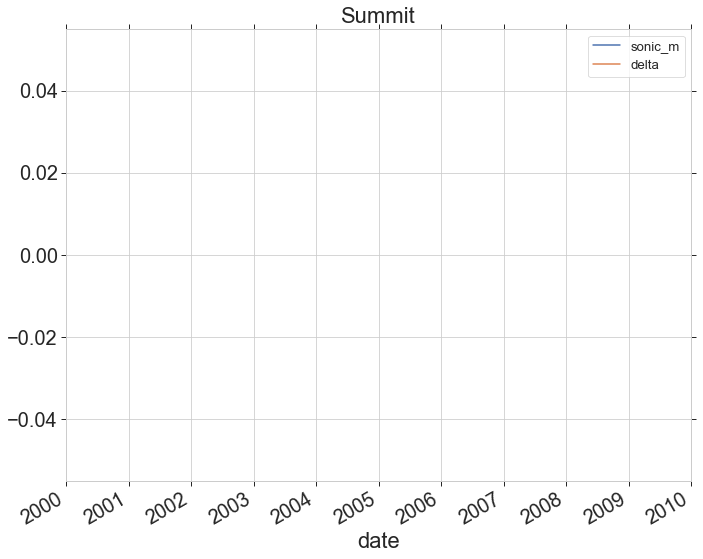

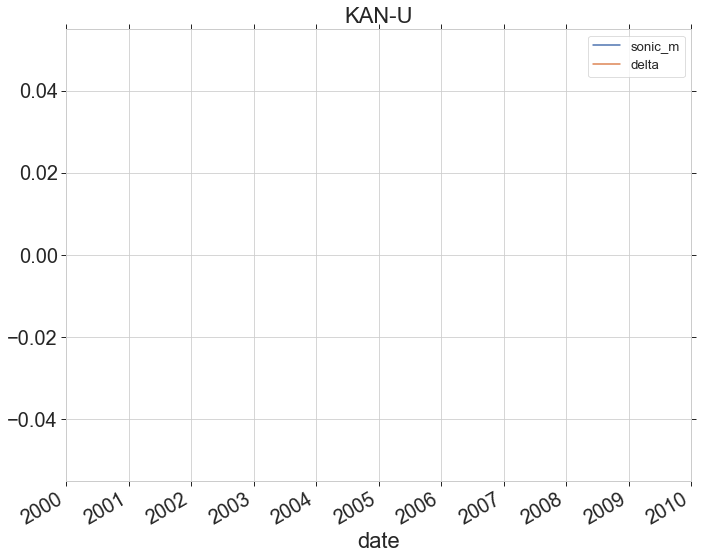

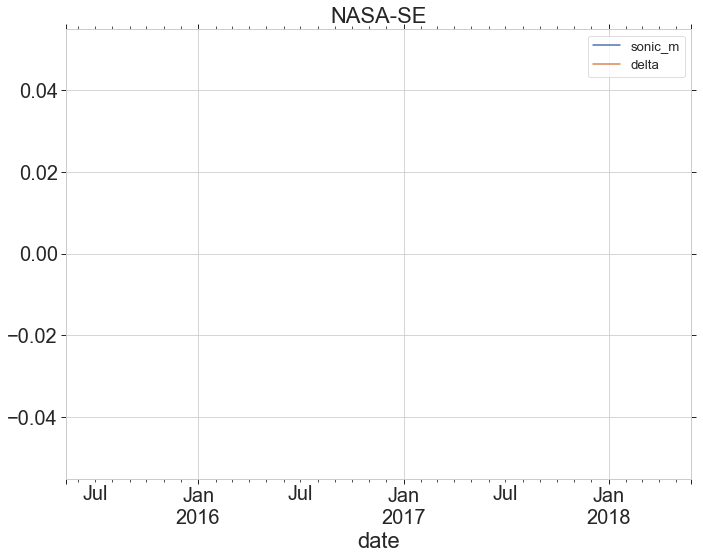

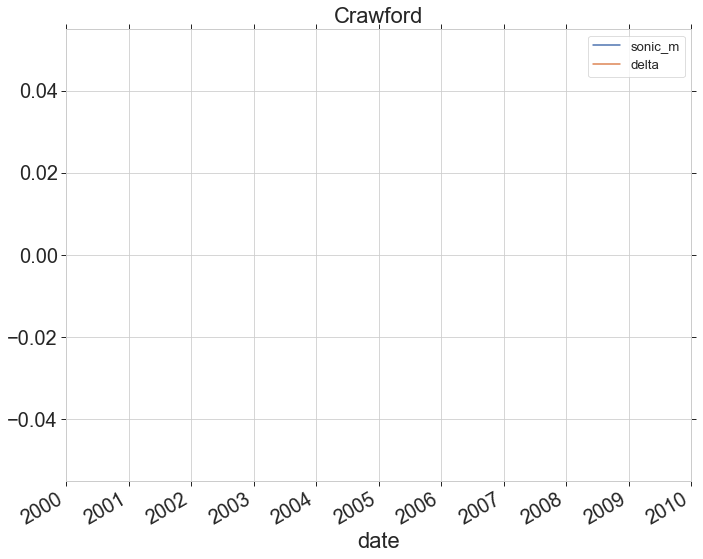

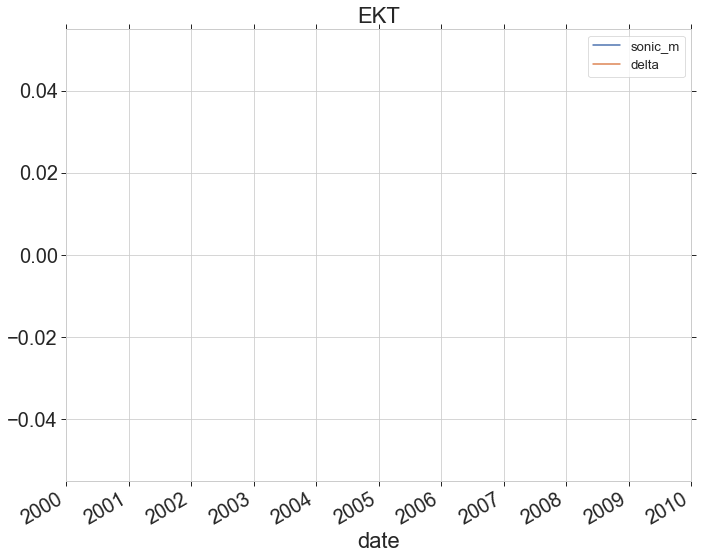

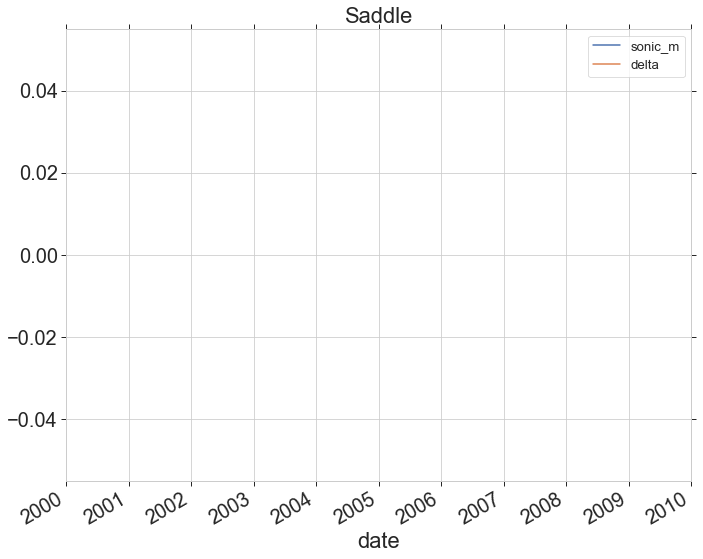

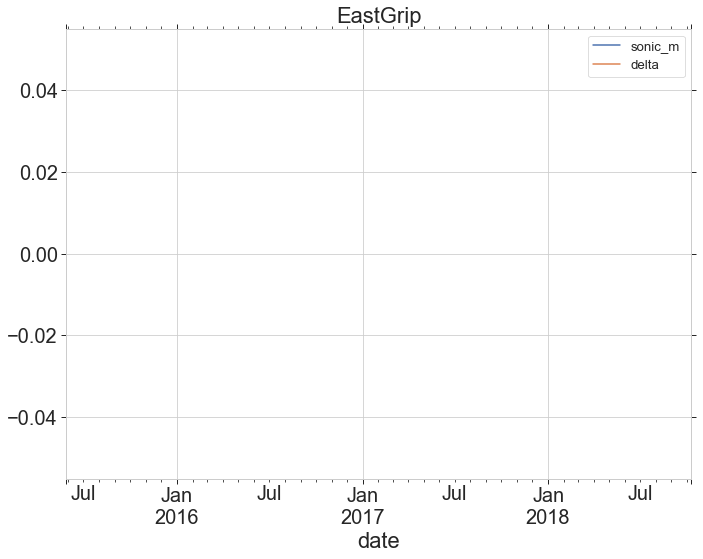

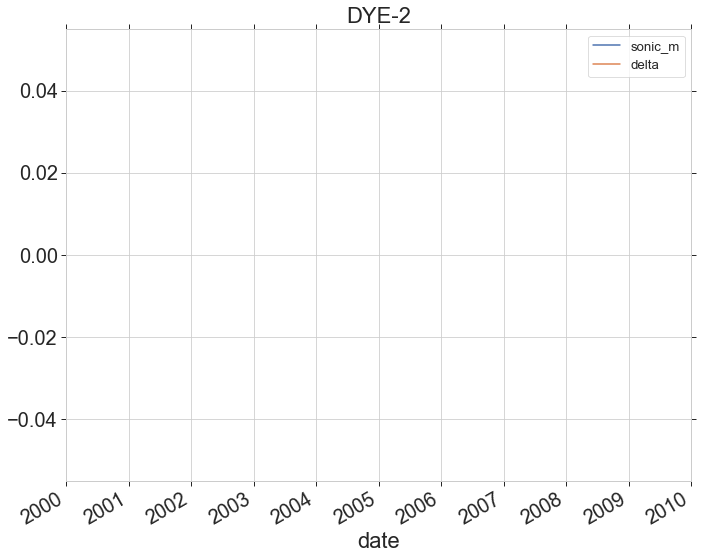

In [38]:
for site in sites:
    sonic_df.loc[site].plot()
    plt.title(site)
    plt.grid(True)

In [39]:
rtd_depth_df=statmeta_df[zz].copy()
xx=statmeta_df.RTD_top_usable_RTD_num
for site in sites:
    vv=rtd_depth_df.loc[site].values
    ri = np.arange(xx.loc[site],24)
    vv[ri]=np.nan
    rtd_depth_df.loc[site]=vv
rtd_d = sonic_df.join(rtd_depth_df, how='inner')
rtd_dc = rtd_d.copy()
rtd_dep = rtd_dc[zz].add(-1*rtd_dc['delta'],axis='rows')

In [40]:
rtd_df=pd.DataFrame.from_records(datatable.Firn_Temp_Daily[:].tolist(),columns=datatable.Firn_Temp_Daily.colnames)
rtd_df.sitename=rtd_df.sitename.str.decode("utf-8")
rtd_df['date']=pd.to_datetime(rtd_df.daynumber_YYYYMMDD.values,format='%Y%m%d')
rtd_df.set_index(['sitename','date'])

daynumber_YYYYMMDD  \
sitename date                             
KAN-U    2015-05-05            20150505   
         2015-05-06            20150506   
         2015-05-07            20150507   
         2015-05-08            20150508   
         2015-05-09            20150509   
...                                 ...   
EastGrip 2018-10-06            20181006   
         2018-10-07            20181007   
         2018-10-08            20181008   
         2018-10-09            20181009   
         2018-10-10            20181010   

                                                          RTD_ohms_avg  \
sitename date                                                            
KAN-U    2015-05-05  [954.55, 956.88, 958.24, 954.1, 957.67, 958.94...   
         2015-05-06  [960.33, 960.63, 961.55, 958.57, 957.99, 958.1...   
         2015-05-07  [967.72, 967.16, 967.21, 965.06, 963.77, 962.5...   
         2015-05-08  [968.53, 967.98, 967.98, 965.85, 964.58, 963.5...   
         2015-05-09  [968.57, 968.03, 968.06, 965.9, 964.57, 963.6,...   
...                                                                ...   
EastGrip 2018-10-06  [887.5, 887.3, 888.0, 890.0, 892.3, 894.0, 896...   
         2018-10-07  [887.4, 887.3, 888.0, 890.0, 892.3, 894.1, 896...   
         2018-10-08  [887.4, 887.3, 888.1, 890.1, 892.3, 894.1, 896...   
         2018-10-09  [887.4, 887.3, 888.1, 890.2, 892.4, 894.2, 896...   
         2018-10-10  [887.5, 887.4, 888.1, 890.2, 892.5, 894.3, 896...   

                                                          RTD_ohms_max  \
sitename date                                                            
KAN-U    2015-05-05  [969.95, 970.61, 980.14, 965.35, 979.32, 979.1...   
         2015-05-06  [982.12, 983.46, 989.56, 977.04, 978.83, 982.7...   
         2015-05-07  [967.99, 967.5, 967.66, 965.36, 964.05, 962.97...   
         2015-05-08  [969.08, 968.58, 968.58, 966.45, 965.14, 964.1...   
         2015-05-09  [968.8, 968.23, 968.39, 966.17, 964.82, 963.79...   
...                                                                ...   
EastGrip 2018-10-06  [887.7, 887.6, 888.2, 890.3, 892.4, 894.2, 896...   
         2018-10-07  [887.7, 887.7, 888.3, 890.3, 892.5, 894.3, 896...   
         2018-10-08  [887.6, 887.5, 888.3, 890.3, 892.5, 894.3, 896...   
         2018-10-09  [887.6, 887.6, 888.3, 890.6, 892.8, 894.6, 896...   
         2018-10-10  [887.7, 887.7, 888.4, 890.5, 892.8, 894.6, 896...   

                                            RTD_temp_avg_uncorrected_C  \
sitename date                                                            
KAN-U    2015-05-05  [-11.61, -11.02, -10.67, -11.73, -10.81, -10.4...   
         2015-05-06  [-10.14, -10.06, -9.83, -10.59, -10.73, -10.7,...   
         2015-05-07  [-8.25, -8.39, -8.38, -8.93, -9.26, -9.57, -10...   
         2015-05-08  [-8.04, -8.18, -8.18, -8.73, -9.05, -9.32, -9....   
         2015-05-09  [-8.03, -8.17, -8.16, -8.72, -9.05, -9.3, -9.6...   
...                                                                ...   
EastGrip 2018-10-06  [-28.67, -28.72, -28.54, -28.03, -27.45, -27.0...   
         2018-10-07  [-28.69, -28.72, -28.54, -28.03, -27.45, -26.9...   
         2018-10-08  [-28.69, -28.72, -28.51, -28.01, -27.45, -26.9...   
         2018-10-09  [-28.69, -28.72, -28.51, -27.98, -27.42, -26.9...   
         2018-10-10  [-28.67, -28.69, -28.51, -27.98, -27.4, -26.94...   

                                            RTD_temp_max_uncorrected_C  \
sitename date                                                            
KAN-U    2015-05-05  [-7.68, -7.51, -5.08, -8.86, -5.29, -5.33, -8....   
         2015-05-06  [-4.57, -4.23, -2.67, -5.87, -5.41, -4.41, -4....   
         2015-05-07  [-8.18, -8.31, -8.27, -8.85, -9.19, -9.46, -9....   
         2015-05-08  [-7.9, -8.03, -8.03, -8.57, -8.91, -9.16, -9.5...   
         2015-05-09  [-7.97, -8.12, -8.08, -8.65, -8.99, -9.25, -9....   
...                                                   

In [41]:
rtd_df.head(3)

,sitename,daynumber_YYYYMMDD,RTD_ohms_avg,RTD_ohms_max,RTD_temp_avg_uncorrected_C,RTD_temp_max_uncorrected_C,RTD_line_correction_ohms_avg,RTD_temp_avg_corrected_C,RTD_temp_max_corrected_C,RTD_depths_m,date
0,KAN-U,20150505,"[954.55, 956.88, 958.24, 954.1, 957.67, 958.94...","[969.95, 970.61, 980.14, 965.35, 979.32, 979.1...","[-11.61, -11.02, -10.67, -11.73, -10.81, -10.4...","[-7.68, -7.51, -5.08, -8.86, -5.29, -5.33, -8....",1.607,"[-12.02, -11.43, -11.08, -12.14, -11.22, -10.9...","[-8.09, -7.92, -5.49, -9.27, -5.7, -5.74, -9.3...","[13.51, 12.51, 11.51, 10.51, 9.51, 9.01, 8.51,...",2015-05-05
1,KAN-U,20150506,"[960.33, 960.63, 961.55, 958.57, 957.99, 958.1...","[982.12, 983.46, 989.56, 977.04, 978.83, 982.7...","[-10.14, -10.06, -9.83, -10.59, -10.73, -10.7,...","[-4.57, -4.23, -2.67, -5.87, -5.41, -4.41, -4....",1.641,"[-10.56, -10.48, -10.24, -11.0, -11.15, -11.12...","[-4.99, -4.65, -3.09, -6.29, -5.83, -4.83, -4....","[13.505709, 12.505709, 11.505709, 10.505709, 9...",2015-05-06
2,KAN-U,20150507,"[967.72, 967.16, 967.21, 965.06, 963.77, 962.5...","[967.99, 967.5, 967.66, 965.36, 964.05, 962.97...","[-8.25, -8.39, -8.38, -8.93, -9.26, -9.57, -10...","[-8.18, -8.31, -8.27, -8.85, -9.19, -9.46, -9....",1.661,"[-8.67, -8.82, -8.8, -9.35, -9.68, -9.99, -10....","[-8.61, -8.73, -8.69, -9.28, -9.61, -9.89, -10...","[13.593843, 12.593843, 11.593843, 10.593843, 9...",2015-05-07


In [42]:
rtd_trun = rtd_df[['sitename','date','RTD_temp_avg_corrected_C']].copy().set_index(['sitename','date'])
rtd_trun.columns = ['T_avg']
rtd_trun[zz]=pd.DataFrame(rtd_trun.T_avg.values.tolist(),index=rtd_trun.index)
rtd_trun.drop('T_avg',axis=1,inplace=True)
rtd_trun.replace(-100.0,np.nan,inplace=True)

In [43]:
site='Summit'
sitetemp=rtd_trun.loc[site]
sitedep = rtd_dep.loc[site]
n_grid = np.linspace(-15,3,61)
time1=sitetemp.index.values
temps = sitetemp.values
depths = sitedep.values
rtd_trun.loc[site]

,rtd0,rtd1,rtd2,rtd3,rtd4,rtd5,rtd6,rtd7,rtd8,rtd9,...,rtd14,rtd15,rtd16,rtd17,rtd18,rtd19,rtd20,rtd21,rtd22,rtd23
date,,,,,,,,,,,,,,,,,,,,,
2015-05-29,-23.959999,-23.990000,-23.219999,-23.430000,-23.200001,-24.059999,-24.219999,-25.180000,-24.700001,-25.330000,...,-25.260000,-17.760000,-17.080000,-14.890000,-8.710000,-12.190000,-10.030000,-8.170000,-11.230000,-8.740000
2015-05-30,-28.930000,-29.049999,-29.230000,-29.639999,-30.120001,-30.370001,-30.700001,-31.129999,-31.590000,-31.840000,...,-29.049999,-23.110001,-20.600000,-20.629999,-15.700000,-21.000000,-15.580000,-16.510000,-17.680000,-16.480000
2015-05-31,-28.980000,-29.110001,-29.340000,-29.750000,-30.250000,-30.530001,-30.889999,-31.340000,-31.799999,-32.099998,...,-29.010000,-24.950001,-22.000000,-18.040001,-12.780000,-19.850000,-9.660000,-10.150000,-12.610000,-9.580000
2015-06-01,-28.959999,-29.080000,-29.309999,-29.740000,-30.219999,-30.530001,-30.879999,-31.340000,-31.799999,-32.099998,...,-29.059999,-25.940001,-22.840000,-18.830000,-16.780001,-20.150000,-14.200000,-15.250000,-16.120001,-14.930000
2015-06-02,-28.910000,-29.059999,-29.290001,-29.719999,-30.200001,-30.480000,-30.860001,-31.320000,-31.750000,-32.049999,...,-29.160000,-26.469999,-23.170000,-17.969999,-16.080000,-20.040001,-14.290000,-15.450000,-15.330000,-17.139999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-03,-28.780001,-28.830000,-28.830000,-28.830000,-28.650000,-28.500000,-28.299999,-28.100000,-27.820000,-27.459999,...,-24.459999,-23.799999,-23.270000,-22.840000,-22.889999,-23.090000,-23.070000,-23.090000,-23.139999,-23.250000
2018-10-04,-28.799999,-28.850000,-28.850000,-28.850000,-28.670000,-28.490000,-28.290001,-28.110001,-27.809999,-27.450001,...,-24.480000,-23.850000,-23.340000,-22.980000,-23.010000,-23.190001,-23.160000,-23.209999,-23.260000,-23.360001
2018-10-05,-28.820000,-28.850000,-28.820000,-28.850000,-28.650000,-28.490000,-28.270000,-28.090000,-27.809999,-27.430000,...,-24.510000,-23.870001,-23.420000,-23.090000,-23.110001,-23.290001,-23.260000,-23.290001,-23.370001,-23.469999


In [44]:
sitetemp.to_pickle('EGRIP_temp.pkl')
sitedep.to_pickle('EGRIP_rtddep.pkl')

In [45]:
### Use the separate script to plot these.

# for site in sites:
#     print(site)
#     sitetemp=rtd_trun.loc[site]
#     sitedep = rtd_dep.loc[site]
#     n_grid = np.linspace(-15,3,61)
#     time=sitetemp.index.values
#     temps = sitetemp.values
#     depths = sitedep.values
#     ro,co=np.shape(temps)
#     t_interp=np.zeros((ro,len(n_grid)))
#     for kk in range(ro):
#             tif = sp.interpolate.interp1d(depths[kk,:],temps[kk,:],bounds_error=False)
#             t_interp[kk,:]= tif(n_grid)
            
#     f1, ax1 = plt.subplots()
#     f1.set_size_inches(12,6)
#     cax1 = ax1.contourf(time,n_grid,t_interp.T,256, extend='both', vmin=max(-50,np.nanmin(t_interp)),vmax=min(0,np.nanmax(t_interp)))
#     cax1.cmap.set_over('cyan')
#     cax1.cmap.set_under('black')
#     ax1.axhline(y=0,color='k')
#     ax1.set_ylabel('depth')
#     ax1.set_xlabel('date')
#     cb1 = f1.colorbar(cax1)
#     cb1.set_label('Temperature (C)')
#     ax1.set_title(site)
# #     f1.savefig('figures/RTD_temp_%s.eps' %site)
#     plt.close(f1)

In [46]:
# rtd_trun.to_pickle('firncover_rtd_temp.pkl')
# rtd_dep.to_pickle('firncover_rtd_depth.pkl')
compaction_df.to_pickle('firncover_compaction.pkl')

# Now we want to find the viscosity, so we need a mean temperature and density for each measurement.

In [47]:
t_interp[4:7,:]

NameError: name 't_interp' is not defined

In [ ]:
site = 'Summit'
sitetemp=rtd_trun.loc[site]
sitedep = rtd_dep.loc[site]
n_grid = np.linspace(-22,0,61)
time=sitetemp.index.values
temps = sitetemp.values
depths = sitedep.values
ro,co=np.shape(temps)
t_interp=np.zeros((ro,len(n_grid)))
for kk in range(ro):
        tif = sp.interpolate.interp1d(depths[kk,:],temps[kk,:],kind='linear',bounds_error=False,fill_value=np.nan)
        try:
            t_interp[kk,:]= tif(n_grid)

            ind = np.where(~np.isnan(t_interp[kk,:]))[0]
            first, last = ind[0], ind[-1]
            t_interp[kk,:first] = t_interp[kk,first]
            t_interp[kk,last + 1:] = t_interp[kk,last]
        except:
            continue
ti_df=pd.DataFrame(data=t_interp,index=rtd_trun.loc['Summit'].index)

site = 'EastGrip'
sitetemp=rtd_trun.loc[site]
sitedep = rtd_dep.loc[site]
n_grid = np.linspace(-22,0,61)
time=sitetemp.index.values
temps = sitetemp.values
depths = sitedep.values
ro,co=np.shape(temps)
t_interp=np.zeros((ro,len(n_grid)))
for kk in range(ro):
        tif = sp.interpolate.interp1d(depths[kk,:],temps[kk,:],kind='linear',bounds_error=False,fill_value=np.nan)
        try:
            t_interp[kk,:]= tif(n_grid)

            ind = np.where(~np.isnan(t_interp[kk,:]))[0]
            first, last = ind[0], ind[-1]
            t_interp[kk,:first] = t_interp[kk,first]
            t_interp[kk,last + 1:] = t_interp[kk,last]
        except:
            continue
ti_df_egr=pd.DataFrame(data=t_interp,index=rtd_trun.loc['EastGrip'].index)

site = 'NASA-SE'
sitetemp=rtd_trun.loc[site]
sitedep = rtd_dep.loc[site]
n_grid = np.linspace(-22,0,61)
time=sitetemp.index.values
temps = sitetemp.values
depths = sitedep.values
ro,co=np.shape(temps)
t_interp=np.zeros((ro,len(n_grid)))
for kk in range(ro):
        tif = sp.interpolate.interp1d(depths[kk,:],temps[kk,:],kind='linear',bounds_error=False,fill_value=np.nan)
        t_interp[kk,:]= tif(n_grid)

        ind = np.where(~np.isnan(t_interp[kk,:]))[0]
        first, last = ind[0], ind[-1]
        t_interp[kk,:first] = t_interp[kk,first]
        t_interp[kk,last + 1:] = t_interp[kk,last]

ti_df_nasa=pd.DataFrame(data=t_interp,index=rtd_trun.loc['NASA-SE'].index)

site = 'Saddle'
sitetemp=rtd_trun.loc[site]
sitedep = rtd_dep.loc[site]
n_grid = np.linspace(-22,0,61)
time=sitetemp.index.values
temps = sitetemp.values
depths = sitedep.values
ro,co=np.shape(temps)
t_interp=np.zeros((ro,len(n_grid)))
for kk in range(ro):
        tif = sp.interpolate.interp1d(depths[kk,:],temps[kk,:],kind='linear',bounds_error=False,fill_value=np.nan)
        t_interp[kk,:]= tif(n_grid)
        try:
            ind = np.where(~np.isnan(t_interp[kk,:]))[0]
            first, last = ind[0], ind[-1]
            t_interp[kk,:first] = t_interp[kk,first]
            t_interp[kk,last + 1:] = t_interp[kk,last]
        except:
            t_interp[kk,:]=np.nan

ti_df_sad=pd.DataFrame(data=t_interp,index=rtd_trun.loc['Saddle'].index)

In [ ]:
deparr = np.arange(0,25,0.1)
sumagehl,sumdenhl = hl_analytic(300,np.arange(0,25,0.1),243,0.23*0.917)
egragehl,egrdenhl = hl_analytic(350,np.arange(0,25,0.1),244,0.14*0.917)
nasaagehl,nasadenhl = hl_analytic(350,np.arange(0,25,0.1),253,0.68*0.917)
sadagehl,saddenhl = hl_analytic(350,np.arange(0,25,0.1),253,0.47*0.917)
crawagehl,crawdenhl = hl_analytic(350,np.arange(0,25,0.1),255,0.5*0.917)
sumageif = sp.interpolate.interp1d(deparr,sumagehl)
egrageif = sp.interpolate.interp1d(deparr,egragehl)
nasaageif = sp.interpolate.interp1d(deparr,nasaagehl)
sadageif = sp.interpolate.interp1d(deparr,nasaagehl)
crawageif = sp.interpolate.interp1d(deparr,nasaagehl)

In [ ]:
core_df['age']=np.zeros_like(core_df.depth)
core_df['lnrho']=np.zeros_like(core_df.depth)
core_df['slope']=np.zeros_like(core_df.depth)

In [ ]:
for core in core_df.xs('Summit',level='site').index.get_level_values(level=0).unique():
    core_df.loc[core,'age']=sumageif(core_df.loc[core,'depth'])
    core_df.loc[core,'lnrho']= -1*np.log(917.0-core_df.loc[core,'density'].values)
    core_df.loc[core,'slope'] = np.polyfit(core_df.loc[core,'age'].values,core_df.loc[core,'lnrho'].values,1)[0]

In [ ]:
summitdf = compaction_df[compaction_df.sitename=='Summit']
sdf2=summitdf.copy()
sdf2['stress']=np.zeros_like(sdf2.hole_init_length)
sdf2['rho']=np.zeros_like(sdf2.hole_init_length)
sdf2['temperature']=np.zeros_like(sdf2.hole_init_length)
sdf2['age']=sumageif(sdf2['hole_botfromsurf'])

for ii in sdf2.index.unique(level='instrument_id'):
    htop = sdf2.loc[ii,'hole_topfromsurf'][0] * -1.0
    hbot = sdf2.loc[ii,'hole_botfromsurf'][0] * -1.0
    qq = ((n_grid<htop) & (n_grid>hbot))
    rr = pd.DataFrame(ti_df.iloc[:,qq].mean(axis=1),columns=['temperature'])
    inter = rr.index.intersection(sdf2.loc[ii].index)
    sdf2.loc[ii,'temperature'] = rr.loc[inter].values.T[0]
    if ii<100:
        sdf2.loc[ii,'stress']=core_df.xs(ii,level='instrument').stress_cu[-1]
        sdf2.loc[ii,'rho']=core_df.xs(ii,level='instrument').density.mean()
    elif ii==101:
        mxx = core_df.xs(31,level='instrument').depth.max()
        sdf2.loc[ii,'stress']=core_df.xs(30,level='instrument').stress_cu[-1]
        sdf2.loc[ii,'rho']=core_df.xs(30,level='instrument')[core_df.xs(30,level='instrument').depth>mxx].density.mean()
    elif ii==102:
        mxx = core_df.xs(32,level='instrument').depth.max()
        sdf2.loc[ii,'stress']=core_df.xs(30,level='instrument').stress_cu[-1]
        sdf2.loc[ii,'rho']=core_df.xs(30,level='instrument')[core_df.xs(30,level='instrument').depth>mxx].density.mean()
    elif ii==103:
        mxx = core_df.xs(31,level='instrument').depth.max()
        sdf2.loc[ii,'stress']=core_df.xs(32,level='instrument').stress_cu[-1]
        sdf2.loc[ii,'rho']=core_df.xs(32,level='instrument')[core_df.xs(32,level='instrument').depth>mxx].density.mean()        

egripdf = compaction_df[compaction_df.sitename=='EastGrip']
egdf2=egripdf.copy()
egdf2['stress']=np.zeros_like(egdf2.hole_init_length)
egdf2['rho']=np.zeros_like(egdf2.hole_init_length)
egdf2['temperature']=np.zeros_like(egdf2.hole_init_length)
egdf2['age']=egrageif(egdf2['hole_botfromsurf'])

for ii in egdf2.index.unique(level='instrument_id'):
    htop = egdf2.loc[ii,'hole_topfromsurf'][0] * -1.0
    hbot = egdf2.loc[ii,'hole_botfromsurf'][0] * -1.0
    qq = ((n_grid<htop) & (n_grid>hbot))
    rr = pd.DataFrame(ti_df_egr.iloc[:,qq].mean(axis=1),columns=['temperature'])
    inter = rr.index.intersection(egdf2.loc[ii].index)
    egdf2.loc[ii,'temperature'] = rr.loc[inter].values.T[0]
    if ii<100:
        egdf2.loc[ii,'stress']=core_df.xs(ii,level='instrument').stress_cu[-2]
        egdf2.loc[ii,'rho']=core_df.xs(ii,level='instrument').density.mean()
    elif ii==104:
        mxx = core_df.xs(28,level='instrument').depth.max()
        egdf2.loc[ii,'stress']=core_df.xs(26,level='instrument').stress_cu[-2]
        egdf2.loc[ii,'rho']=core_df.xs(26,level='instrument')[core_df.xs(26,level='instrument').depth>mxx].density.mean()
    elif ii==105:
        mxx = core_df.xs(27,level='instrument').depth.max()
        egdf2.loc[ii,'stress']=core_df.xs(26,level='instrument').stress_cu[-2]
        egdf2.loc[ii,'rho']=core_df.xs(26,level='instrument')[core_df.xs(26,level='instrument').depth>mxx].density.mean()
    elif ii==106:
        mxx = core_df.xs(27,level='instrument').depth.max()
        egdf2.loc[ii,'stress']=core_df.xs(28,level='instrument').stress_cu[-2]
        egdf2.loc[ii,'rho']=core_df.xs(28,level='instrument')[core_df.xs(28,level='instrument').depth>mxx].density.mean() 
                        
nasadf = compaction_df[compaction_df.sitename=='NASA-SE']
nadf2=nasadf.copy()
nadf2['stress']=np.zeros_like(nadf2.hole_init_length)
nadf2['rho']=np.zeros_like(nadf2.hole_init_length)
nadf2['temperature']=np.zeros_like(nadf2.hole_init_length)
nadf2['age']=nasaageif(nadf2['hole_botfromsurf'])

for ii in nadf2.index.unique(level='instrument_id'):
    htop = nadf2.loc[ii,'hole_topfromsurf'][0] * -1.0
    hbot = nadf2.loc[ii,'hole_botfromsurf'][0] * -1.0
    qq = ((n_grid<htop) & (n_grid>hbot))
    rr = pd.DataFrame(ti_df_nasa.iloc[:,qq].mean(axis=1),columns=['temperature'])
    inter = rr.index.intersection(nadf2.loc[ii].index)
    nadf2.loc[ii,'temperature'] = rr.loc[inter].values.T[0]
    if ii<100:
        nadf2.loc[ii,'stress']=core_df.xs(ii,level='instrument').stress_cu[-2]
        nadf2.loc[ii,'rho']=core_df.xs(ii,level='instrument').density.mean()
    elif ii==107:
        mxx = core_df.xs(14,level='instrument').depth.max()
        nadf2.loc[ii,'stress']=core_df.xs(13,level='instrument').stress_cu[-2]
        nadf2.loc[ii,'rho']=core_df.xs(13,level='instrument')[core_df.xs(13,level='instrument').depth>mxx].density.mean()
    elif ii==108:
        mxx = core_df.xs(15,level='instrument').depth.max()
        nadf2.loc[ii,'stress']=core_df.xs(13,level='instrument').stress_cu[-2]
        nadf2.loc[ii,'rho']=core_df.xs(13,level='instrument')[core_df.xs(13,level='instrument').depth>mxx].density.mean()
    elif ii==109:
        mxx = core_df.xs(14,level='instrument').depth.max()
        nadf2.loc[ii,'stress']=core_df.xs(15,level='instrument').stress_cu[-2]
        nadf2.loc[ii,'rho']=core_df.xs(15,level='instrument')[core_df.xs(15,level='instrument').depth>mxx].density.mean()          
        
saddledf = compaction_df[compaction_df.sitename=='Saddle']
saddf2=saddledf.copy()
saddf2 = saddf2[((saddf2.index.get_level_values("date")>'2016-01-01')&(saddf2.index.get_level_values("date")<'2017-08-21'))]
saddf2['stress']=np.zeros_like(saddf2.hole_init_length)
saddf2['rho']=np.zeros_like(saddf2.hole_init_length)
saddf2['temperature']=np.zeros_like(saddf2.hole_init_length)
saddf2['age']=sadageif(saddf2['hole_botfromsurf'])

for ii in saddf2.index.unique(level='instrument_id'):
    htop = saddf2.loc[ii,'hole_topfromsurf'][0] * -1.0
    hbot = saddf2.loc[ii,'hole_botfromsurf'][0] * -1.0
    qq = ((n_grid<htop) & (n_grid>hbot))
    rr = pd.DataFrame(ti_df_sad.iloc[:,qq].mean(axis=1),columns=['temperature'])
    rr = rr.reindex(saddf2.loc[ii].index,method='nearest')
    inter = rr.index.intersection(saddf2.loc[ii].index)
    saddf2.loc[ii,'temperature'] = rr.loc[inter].values.T[0]
    if ii<100:
        saddf2.loc[ii,'stress']=core_df.xs(ii,level='instrument').stress_cu[-2]
        saddf2.loc[ii,'rho']=core_df.xs(ii,level='instrument').density.mean()

# crawforddf = compaction_df[compaction_df.sitename=='Crawford']
# crawdf2=crawforddf.copy()
# crawdf2 = crawdf2[((crawdf2.index.get_level_values("date")>'2016-01-01')&(crawdf2.index.get_level_values("date")<'2017-08-21'))]
# crawdf2['stress']=np.zeros_like(crawdf2.hole_init_length)
# crawdf2['rho']=np.zeros_like(crawdf2.hole_init_length)
# crawdf2['temperature']=np.zeros_like(crawdf2.hole_init_length)
# crawdf2['age']=crawageif(crawdf2['hole_botfromsurf'])

# for ii in crawdf2.index.unique(level='compaction_instrument_id'):
#     htop = crawdf2.loc[ii,'hole_topfromsurf'][0] * -1.0
#     hbot = crawdf2.loc[ii,'hole_botfromsurf'][0] * -1.0
#     qq = ((n_grid<htop) & (n_grid>hbot))
#     rr = pd.DataFrame(ti_df_craw.iloc[:,qq].mean(axis=1),columns=['temperature'])
#     rr = rr.reindex(crawdf2.loc[ii].index,method='nearest')
#     inter = rr.index.intersection(crawdf2.loc[ii].index)
#     crawdf2.loc[ii,'temperature'] = rr.loc[inter].values.T[0]
#     if ii<100:
#         crawdf2.loc[ii,'stress']=core_df.xs(ii,level='instrument').stress_cu[-2]
#         crawdf2.loc[ii,'rho']=core_df.xs(ii,level='instrument').density.mean()

In [ ]:
dc=dict()
sints_s = [30,31,32,33,101,102,103]
# sints_s = [31]
sints_e = [26,27,28,104,105,106]
sints_n = [13,14,15,107,108,109]
sints_sad = [17,18,19,20]
sints_all = [30,31,32,33,41,101,102,103,26,27,28,40,104,105,106,13,14,15,37,107,108,109]
sints_all = [30,31,32,33,41,101,102,103,26,27,28,40,104,105,106]#,104,108]
rhoi = 917.0
qguess = 60000.0
R = 8.314
for bb in sints_n:
    if bb in sints_s:
        s4=sdf2.loc[bb][['compaction_borehole_length_m','hole_init_length','compdiff','totcomp','stress','rho','temperature','age']]
    elif bb in sints_e:
        s4=egdf2.loc[bb][['compaction_borehole_length_m','hole_init_length','compdiff','totcomp','stress','rho','temperature','age']]
    elif bb in sints_n:
        s4=nadf2.loc[bb][['compaction_borehole_length_m','hole_init_length','compdiff','totcomp','stress','rho','temperature','age']]
    elif bb in sints_sad:
        s4=saddf2.loc[bb][['compaction_borehole_length_m','hole_init_length','compdiff','totcomp','stress','rho','temperature','age']]
    s5=s4.resample('2W').agg({'compaction_borehole_length_m':np.min, 'hole_init_length':np.mean, 'compdiff': np.sum, 'totcomp': np.max, 'stress': np.mean, 'rho': np.mean, 'temperature':np.mean, 'age':np.mean})
    
    # Now do figure out the compaction rates and strain on all the holes.
    # s5['strain']=s5['compaction_borehole_length_m'].apply(strainfun)
    s5['strain'] = -1*np.log(s5['compaction_borehole_length_m']/s5['compaction_borehole_length_m'][0])
    s5['ss1970']=(s5.index-epoch).total_seconds()
    s5['filtstrain']=0*s5['strain']
    s5['strainrate']=0*s5['strain']
    s5['filtstrainrate']=0*s5['strain']
    s5['comprate']=0*s5['strain']
    s5['filttotcomp']=0*s5['strain']
    s5['filtcomprate']=0*s5['strain']

    # uids = s5.index.get_level_values(0).unique()
    # for ii in uids:
    grad = np.gradient(s5['strain'],s5['ss1970'])
    s5['strainrate'] = grad # units: per second
    comprate = np.gradient(s5['totcomp'],s5['ss1970'])
    s5['comprate'] = comprate # units: per second
#     try:
    filtstr = smooth(s5['strain'])
    filtgrad = np.gradient(filtstr,s5['ss1970'])
    s5['filtstrain'] = filtstr # units: per second
    s5['filtstrainrate'] = filtgrad    
    filtcomp = smooth(s5['totcomp'])
    filtcomprate = np.gradient(filtcomp,s5['ss1970'])
    s5['filttotcomp'] = filtcomp # units: per second
    s5['filtcomprate'] = filtcomprate
    s5['srsratio'] = s5.rho * s5.filtstrainrate / s5.stress
    s5['kguess'] = s5.srsratio / ((rhoi-s5.rho) * np.exp(-qguess/(R*(s5.temperature+273.15))))
    s5 = s5[pd.notnull(s5['filtstrainrate'])]
#     except:
#         pass
    dstr = 'df'+str(bb)
    dc[dstr]=s5


In [ ]:
# kg=np.linspace(1.0e-6,3.0e-1,400) # for if we remove the age.
# kg=np.linspace(1e13,1e15,600)
kg=np.linspace(5e9,1e10,600)
q=np.linspace(56000,65000,400)
qt=np.tile(q,(len(kg),1)).T
kt=np.tile(kg,(len(q),1))
Qpref=60000
rmsdict = dict()
rmsexpdict = dict()
krmsd = dict()

blen = sum(len(dc[dct].srsratio) for dct in dc.keys())
minsmat = np.empty((blen,2))
ksmat = np.empty((blen,1))
ll = 0
for jj,key in enumerate(dc.keys()):
#     minsmat = np.empty((len(dc[key].srsratio),2))
#     for ii, val in enumerate(dc[key].srsratio): # option a
    for ii, val in enumerate(dc[key].filtstrainrate): # option b: rms error in m/s
        T = dc[key].temperature[ii]+273.15
#         kqmat = (rhoi-dc[key].rho[ii]) * kt * np.exp(-1*qt/(8.314*T)) #option a
        kqmat = (rhoi-dc[key].rho[ii]) * kt * np.exp(-1*qt/(8.314*T)) * dc[key].stress[ii] / dc[key].rho[ii] / dc[key].age[ii] #option b
        kvec_s = (rhoi-dc[key].rho[ii]) * kg * np.exp(-1*Qpref/(8.314*T)) * dc[key].stress[ii] / dc[key].rho[ii] / dc[key].age[ii] #option b
#         kvec_s = (rhoi-dc[key].rho[ii]) * kg * np.exp(-1*Qpref/(8.314*T)) * dc[key].stress[ii]**2 / dc[key].rho[ii] / dc[key].age[ii]**2 #option b
        rmsdict[ll] = (kqmat - val)**2
        krmsd[ll] = (kvec_s - val)**2
        rmsexpdict[ll] = np.exp(-1*q/(8.314*T))
        if np.isnan(rmsdict[ll]).any():
            print(key)
            print(val)
            print(ll)
        ind = np.unravel_index(np.argmin(rmsdict[ll], axis=None), rmsdict[ll].shape)
        kmin = kt[ind]
        qmin = qt[ind]
        minsmat[ll,0]=kmin
        minsmat[ll,1]=qmin
        
        ind2 = np.argmin(krmsd[ll])
        kmin = kg[ind2]
        ksmat[ll] = kmin
        
        ll+=1
        
v = rmsdict.values()
ke = rmsdict.keys()
rmse = np.sqrt(sum(v)/len(ke))

In [ ]:
f4,a4=plt.subplots()
n, bins, patches=a4.hist(ksmat,20)

In [ ]:
f1,a1 = plt.subplots()
a1.plot(minsmat[:,0],minsmat[:,1],'.')


In [ ]:
cra = np.arange(0,len(minsmat[:,1]))
f3,a3 = plt.subplots()
a3.scatter(minsmat[:,0],minsmat[:,1],c=cra)
# a3.set_xlim(0,1e-3)

In [ ]:
yy=rmse.min()
ex = np.floor(np.log10(np.abs(yy)))
cmax = ((np.ceil(yy/1.0*10**(ex+1)))*1.0*10**(ex+1))/1.1
cmin = ((np.ceil(yy/1.0*10**(ex)))*1.0*10**(ex))*7.5
rmi = rmse.min()
f2,a2 = plt.subplots()
lels = np.linspace(cmin,cmax,41)
cax = a2.contourf(kt,qt,rmse,levels = lels,extend = 'max')
cax.cmap.set_over('white')
a2.set_xlabel('k')
a2.set_ylabel('Q')
plt.colorbar(cax)

In [ ]:
lels=np.linspace(1e-27,1e-20,256)
f10,a10=plt.subplots()
cax = a10.contourf(kg,q,rmsdict[10],levels=lels,extend='max')
plt.colorbar(cax)
a10.set_xlabel('k')
a10.set_ylabel('Q')

In [ ]:
ks = np.array([9.9e8,7.2e9,8.5e9])
acs = np.array([0.68,0.23,0.14])
f8,a8 = plt.subplots()
a8.scatter(acs,ks)

In [ ]:
np.polyfit(acs,ks,1)

In [ ]:
f7,a7=plt.subplots()
a7.plot(sonic_df.loc['NASA-SE'].delta.values)

In [ ]:
summitdf.loc[30]['2016']

In [ ]:
compaction_df[compaction_df.sitename=='Summit'].head()

In [ ]:
f1,a1=plt.subplots()
compaction_df.loc[30].comprate.plot(ax=a1)

In [ ]:
compaction_df.loc[30,'2016-01-01'].totcomp-compaction_df.loc[30,'2016-12-31'].totcomp

In [ ]:
compaction_df.loc[30].resample('a').mean()*spy